<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 20px; height: 55px">

# Autocorrelations and time series decomposition



---

## Learning Objectives

### Core

- Calculate and plot autocorrelation and partial autocorrelation coefficients
- Read and interpret the autocorrelation plots
- Obtain a time series decomposition into trend, seasonal and residual components
- Know about stationarity as an important model requirement
- Use differencing to remove (polynomial) trends

### Target

- Know about differences between pandas and statsmodels auotcorrelation functions

<h1>Lesson Guide<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Learning-Objectives" data-toc-modified-id="Learning-Objectives-1">Learning Objectives</a></span><ul class="toc-item"><li><span><a href="#Core" data-toc-modified-id="Core-1.1">Core</a></span></li><li><span><a href="#Target" data-toc-modified-id="Target-1.2">Target</a></span></li></ul></li><li><span><a href="#Load-the-Unemployment-Data" data-toc-modified-id="Load-the-Unemployment-Data-2">Load the Unemployment Data</a></span></li><li><span><a href="#Create-a-Datetime-Index" data-toc-modified-id="Create-a-Datetime-Index-3">Create a Datetime Index</a></span></li><li><span><a href="#Visually-Examine-the-Unemployment-Rate" data-toc-modified-id="Visually-Examine-the-Unemployment-Rate-4">Visually Examine the Unemployment Rate</a></span></li><li><span><a href="#Autocorrelation-and-the-Autocorrelation-Function-(ACF)" data-toc-modified-id="Autocorrelation-and-the-Autocorrelation-Function-(ACF)-5">Autocorrelation and the Autocorrelation Function (ACF)</a></span><ul class="toc-item"><li><span><a href="#Computing-Autocorrelation" data-toc-modified-id="Computing-Autocorrelation-5.1">Computing Autocorrelation</a></span></li><li><span><a href="#Autocorrelation-Using-Statsmodels" data-toc-modified-id="Autocorrelation-Using-Statsmodels-5.2">Autocorrelation Using Statsmodels</a></span></li></ul></li><li><span><a href="#Partial-Autocorrelation-and-the-Partial-Autocorrelation-Function-(PACF)" data-toc-modified-id="Partial-Autocorrelation-and-the-Partial-Autocorrelation-Function-(PACF)-6">Partial Autocorrelation and the Partial Autocorrelation Function (PACF)</a></span></li><li><span><a href="#Time-Series-Decomposition" data-toc-modified-id="Time-Series-Decomposition-7">Time Series Decomposition</a></span><ul class="toc-item"><li><ul class="toc-item"><li><span><a href="#Questions:" data-toc-modified-id="Questions:-7.0.1">Questions:</a></span></li></ul></li></ul></li><li><span><a href="#Differencing-a-time-series-and-stationarity" data-toc-modified-id="Differencing-a-time-series-and-stationarity-8">Differencing a time series and stationarity</a></span><ul class="toc-item"><li><span><a href="#Difference-the-unemployment-rate-and-plot" data-toc-modified-id="Difference-the-unemployment-rate-and-plot-8.1">Difference the unemployment rate and plot</a></span></li><li><span><a href="#Compare-the-(partial)-autocorrelations-of-the-differenced-and-original-time-series" data-toc-modified-id="Compare-the-(partial)-autocorrelations-of-the-differenced-and-original-time-series-8.2">Compare the (partial) autocorrelations of the differenced and original time series</a></span></li><li><span><a href="#Conclusions" data-toc-modified-id="Conclusions-8.3">Conclusions</a></span></li></ul></li></ul></div>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime

plt.style.use('fivethirtyeight')

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
# this will filter out a lot of future warnings from statsmodels
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

## Load the Unemployment Data

This is historical quarterly data regarding unemployment rates in the United States. First, perform any necessary cleaning.

In [4]:
data = pd.read_csv('./unemployment_timeseries/seasonally-adjusted-quarterly-us.csv')
data.dropna(inplace=True)

In [5]:
data.head()

,Quarter,Seasonally adjusted quarterly U.S. unemployment rates from 1948 to 1993
0,1948Q1,3.733%
1,1948Q2,3.667%
2,1948Q3,3.767%
3,1948Q4,3.833%
4,1949Q1,4.667%


In [6]:
data.columns = ['year_quarter', 'unemployment_rate']
data['unemployment_rate'] = data['unemployment_rate'].map(lambda x: float(str(x).replace('%','')))
data.dropna(inplace=True)

## Create a Datetime Index

This is quarterly data, so converting to datetime is a bit complicated. `.dt.to_period('Q')` will help us represent the string as a datetime object.

In [7]:
data['date'] = pd.to_datetime(data.year_quarter).dt.to_period('Q')
data.set_index('date', inplace=True, drop=True)
data.index = data.index.to_timestamp()
data.head()

,year_quarter,unemployment_rate
date,,
1948-01-01,1948Q1,3.733
1948-04-01,1948Q2,3.667
1948-07-01,1948Q3,3.767
1948-10-01,1948Q4,3.833
1949-01-01,1949Q1,4.667


## Visually Examine the Unemployment Rate

Plot the unemployment rate.

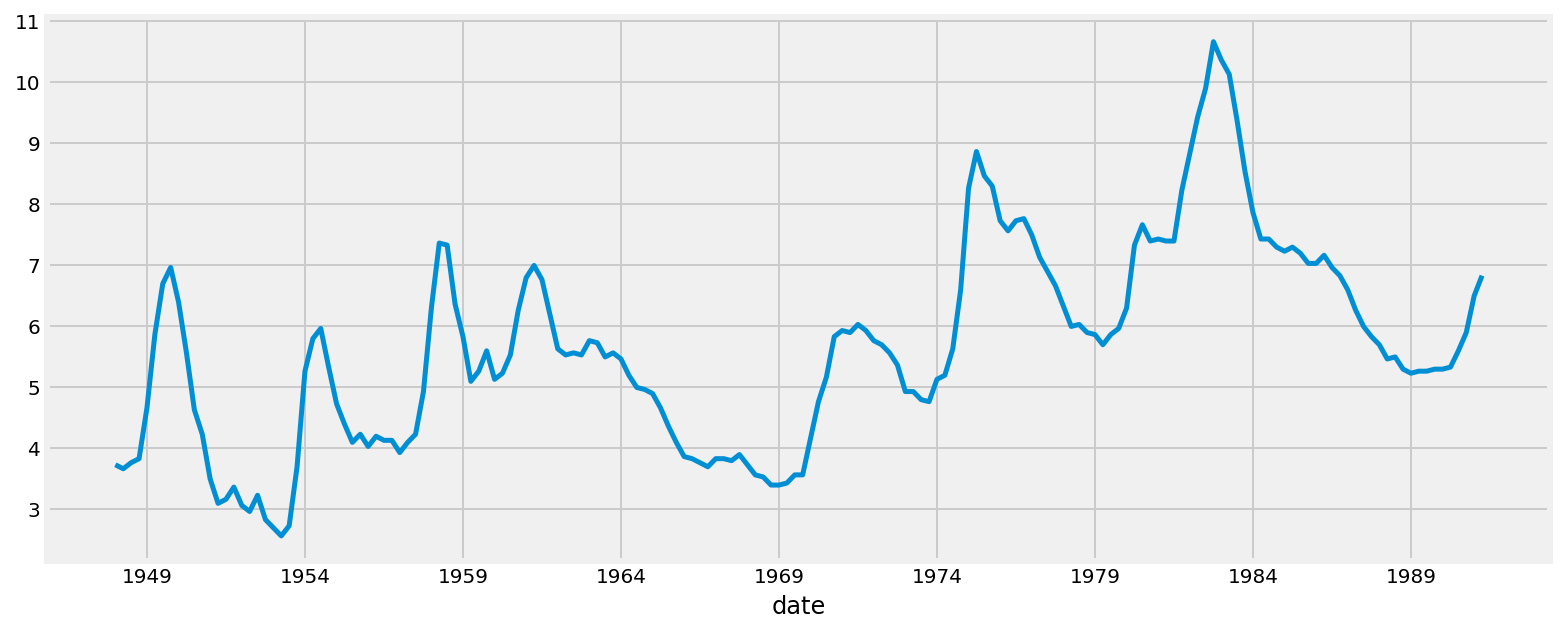

In [8]:
data['unemployment_rate'].plot(lw=2.5, figsize=(12,5));

##  Autocorrelation and the Autocorrelation Function (ACF)

In previous weeks, our analyses have been concerned with the correlation between two or more variables (height and weight, education and salary, etc.). In time series data, autocorrelation is a measure of _how correlated a variable is with itself_.

Specifically, autocorrelation measures how closely earlier values relate to values that occur later in time.

Examples of autocorrelation are:

    In stock market data, the stock price at one point is correlated with the stock 
    price of the point that's directly prior in time. 
    
    In sales data, sales on a Saturday are likely correlated with 
    sales on the next Saturday and the previous Saturday, as well as other days to more
    or less of an extent.

Below is the formula for the autocorrelation function (ACF):

Given measurements $x_1, x_2, x_3, \ldots, x_n$ at time points $t_1, t_2, t_3, \ldots, t_n$:

$${\rm acf}({\rm lag_k}) = \frac{\sum_{t=k+1}^{n}\left(\;x_t - \bar{x}\;\right)\left(\;x_{t-k} - \bar{x}\;\right)}{\sum_{t=1}^n\left(\;x_t - \bar{x}\;\right)^2}$$

Compare this to the formula for correlation:

Given measurements $x_1, x_2, x_3, \ldots, x_n$ and measurements $y_1, y_2, y_3, \ldots, y_n$:

$$r_{xy} = \frac{\sum_{i=1}^{n}\left(\;x_i - \bar{x}\;\right)\left(\;y_{i} - \bar{y}\;\right)}{\sqrt{\left(\sum_{i=1}^{n}\left(\;x_i - \bar{x}\;\right)^2\sum_{i=1}^n\left(\;y_i - \bar{y}\;\right)^2\right)}}$$


In this sum, the **lag** $k$ indicates to sum over all pairs of points which are that lag apart.

### Computing Autocorrelation

To compute autocorrelation, we fix a lag, _k_, which is the delta between the given point and the prior point used to compute the correlation.

With a _k_ value of 1, we'd compute how correlated a value is with the value that's immediately prior. With a _k_ value of 10, we'd compute how correlated a variable is with the value that's 10 time points prior.

In [9]:
urate = data.unemployment_rate

In [10]:
np.array([urate.autocorr(lag=k) for k in range(20)])

array([1.        , 0.96480692, 0.88457618, 0.78647225, 0.69154374,
       0.61535186, 0.56076382, 0.5208759 , 0.48991528, 0.46634242,
       0.4434692 , 0.41783184, 0.39321798, 0.37490436, 0.36294138,
       0.36032148, 0.36243806, 0.3588273 , 0.34360617, 0.31740037])

That is the way how pandas calculates autocorrelations:

In [11]:
def pandas_autocorr(y,lag=1):
    X = pd.DataFrame({'a':y,'b':y.shift(lag)}).copy()
    X.dropna(inplace=True)
    autocorr = X.corr().iloc[0,1]
    return autocorr

In [12]:
np.array([pandas_autocorr(urate,lag=k) for k in range(20)])

array([1.        , 0.96480692, 0.88457618, 0.78647225, 0.69154374,
       0.61535186, 0.56076382, 0.5208759 , 0.48991528, 0.46634242,
       0.4434692 , 0.41783184, 0.39321798, 0.37490436, 0.36294138,
       0.36032148, 0.36243806, 0.3588273 , 0.34360617, 0.31740037])

### Autocorrelation Using Statsmodels

Statsmodels comes with some convenient packages for calculating and plotting autocorrelation. Load up these two functions and try them out:

```python
from statsmodels.tsa.stattools import acf
from statsmodels.graphics.tsaplots import plot_acf
```

In [13]:
from statsmodels.tsa.stattools import acf

Note that statsmodels calculates autocorrelations in a slightly different way:

In [14]:
acf(urate,nlags=20)

array([1.        , 0.95950578, 0.87513008, 0.77480906, 0.67860558,
       0.60302767, 0.54946953, 0.50980855, 0.47862666, 0.45530485,
       0.43290704, 0.40733564, 0.38242446, 0.36262662, 0.34831031,
       0.34311303, 0.34269765, 0.33602242, 0.31802897, 0.29043284,
       0.25556895])

In [15]:
def statsmodel_autocorr(y,lag=1):
    
    if lag==0:
        return 1.0
    
    else:
        X = pd.DataFrame({'a':y.values[:-lag],'b':y.values[lag:]})

        numerator = np.sum((X.loc[:,'a']-y.mean())*(X.loc[:,'b']-y.mean()))
        denom = ((y-y.mean())**2).sum()
        autocorr = numerator/denom

        return autocorr

In [16]:
np.array([statsmodel_autocorr(urate,lag=k) for k in range(20)])

array([1.        , 0.95950578, 0.87513008, 0.77480906, 0.67860558,
       0.60302767, 0.54946953, 0.50980855, 0.47862666, 0.45530485,
       0.43290704, 0.40733564, 0.38242446, 0.36262662, 0.34831031,
       0.34311303, 0.34269765, 0.33602242, 0.31802897, 0.29043284])

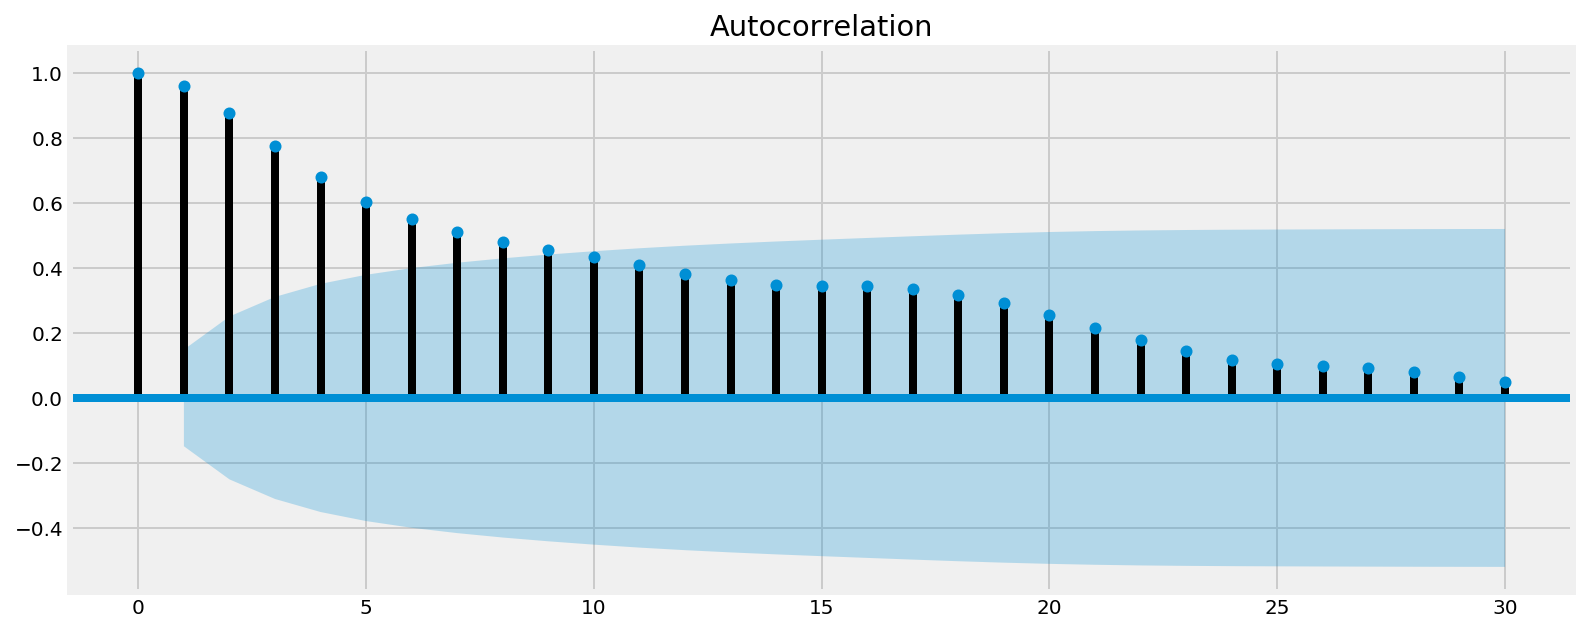

In [17]:
from statsmodels.graphics.tsaplots import plot_acf

fig, ax = plt.subplots(figsize=(12,5))
plot_acf(urate, lags=30, ax=ax)
plt.show()

## Partial Autocorrelation and the Partial Autocorrelation Function (PACF)


Another important chart for diagnosing your time series is the partial autocorrelation chart (PACF). This is similar to autocorrelation, but, instead of being just the correlation at increasing lags, it is the correlation at a given lag, _controlling for the effect of lags in between._

Load up the sister functions for partial autocorrelation from Statsmodels and test them out on the differenced time series.

```python
from statsmodels.tsa.stattools import pacf
from statsmodels.graphics.tsaplots import plot_pacf
```

In [18]:
from statsmodels.tsa.stattools import pacf

In [19]:
pacf(urate,nlags=20)

array([ 1.        ,  0.96505205, -0.67010933,  0.21691526,  0.07494577,
        0.21322536, -0.09593115, -0.05491075,  0.07521878,  0.14700603,
       -0.18064033, -0.01381037,  0.1414165 ,  0.13517355, -0.10704305,
        0.10418921, -0.0958789 , -0.08324834, -0.07692577,  0.08321147,
       -0.05132902])

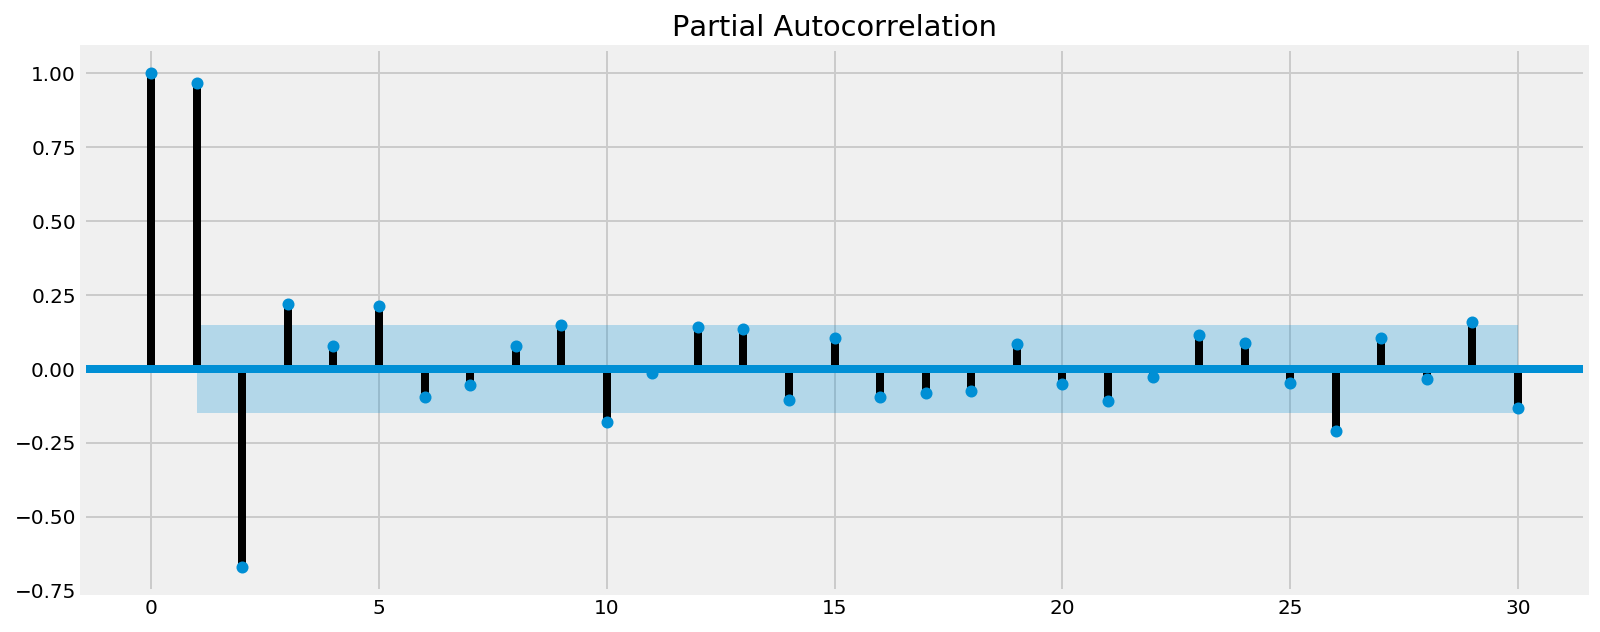

In [20]:
from statsmodels.graphics.tsaplots import plot_pacf

fig, ax = plt.subplots(figsize=(12,5))
plot_pacf(urate, lags=30, ax=ax)
plt.show()

The time series models we are going to consider try to capture the information contained in the (partial) autocorrelations.

Let's create a function to display autocorrelations and partial autocorrelations together.

In [21]:
def autocorr_plots(y, lags=None):
    fig, ax = plt.subplots(ncols=2, figsize=(12, 4), sharey=True)
    plot_acf(y, lags=lags, ax=ax[0])
    plot_pacf(y, lags=lags, ax=ax[1])
    return fig, ax

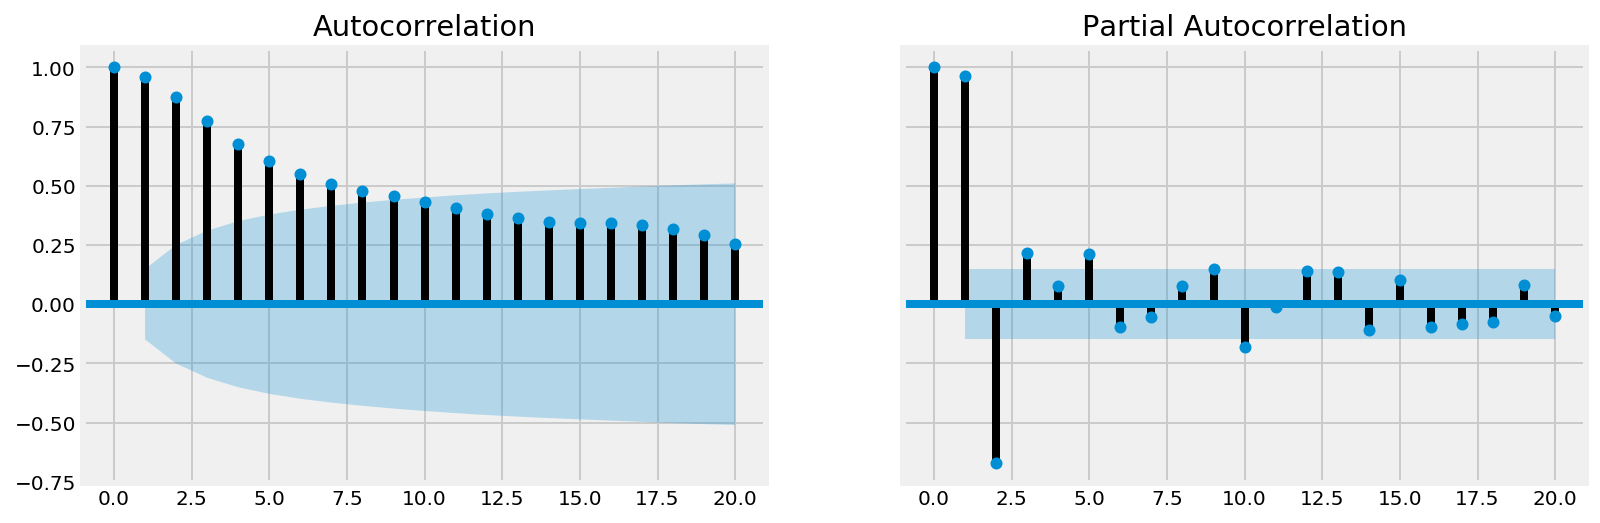

In [22]:
fig, ax = autocorr_plots(urate,lags=20)

## Time Series Decomposition

$$ Y_t = T_t + S_t + R_t $$

- $Y_t = $ observed value at time $t$
- $T_t = $ trend component, *long-term behavior*
- $S_t = $ seasonality component, *periodic fluctuations*
- $R_t = $ residual, *non-periodic fluctuations*


> The decomposition above is additive; it can also be multiplicative.


There are several algorithms for performing this decomposition

- Classical decomp., [https://www.otexts.org/fpp/6/3](https://www.otexts.org/fpp/6/3)
- X-12-ARIMA, [https://www.otexts.org/fpp/6/4](https://www.otexts.org/fpp/6/4)
- STL, [https://www.otexts.org/fpp/6/5](https://www.otexts.org/fpp/6/5)

See also `seasonal_decompose` in `statsmodel.tsa.seasonal`.  

> Nice tutorial here: [http://machinelearningmastery.com/decompose-time-series-data-trend-seasonality/](http://machinelearningmastery.com/decompose-time-series-data-trend-seasonality/)


#### Questions:

- *What is the long-term behavior of my series?*
- *How does my time series fluctuate?*


In [23]:
from statsmodels.tsa.seasonal import seasonal_decompose

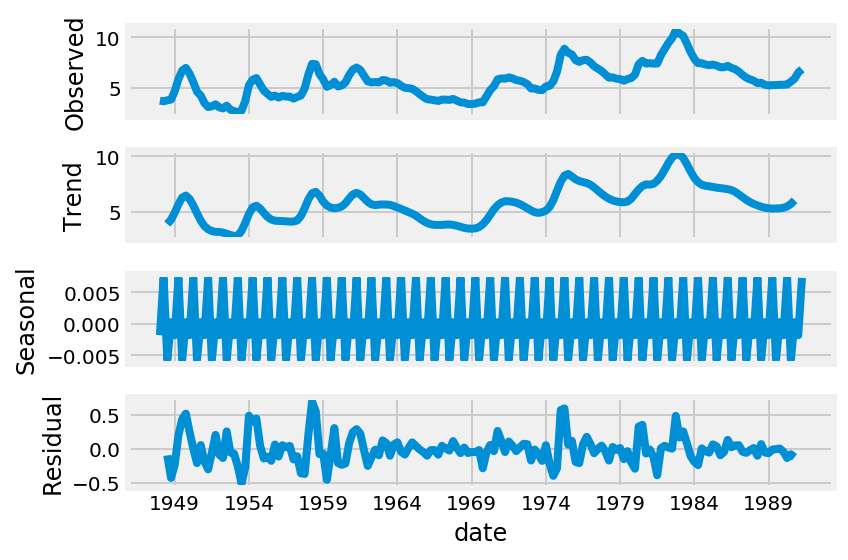

In [24]:
result = seasonal_decompose(urate,freq=4)
result.plot();

In [25]:
result.resid[:10]

date
1948-01-01         NaN
1948-04-01         NaN
1948-07-01   -0.094035
1948-10-01   -0.425747
1949-01-01   -0.231318
1949-04-01    0.201224
1949-07-01    0.438840
1949-10-01    0.520753
1950-01-01    0.251682
1950-04-01    0.009724
Freq: QS-OCT, Name: unemployment_rate, dtype: float64

## Differencing a time series and stationarity

If a time series is stationary, the mean, variance, and covariance are unchanged by time shifts. Forecasting methods typically assume that the time series you are forecasting on are stationary, or at least approximately stationary. For any two instances in time t and s one has:

$${\rm E}(Y_t) = \mu$$
$${\rm Var}(Y_t) =  \sigma^2$$
$${\rm Cov}(Y_t, Y_s) =  \gamma(|t - s|)$$

The last relation implies that the covariance between two time points depends only on the time difference between them, the so-called lag, i.e. taking t=10, s=20 or t=15, s=25 would give the same covariance.

If a time series is not stationary, often it can be transformed to a stationary form. The most common way to make a time series stationary is to perform "differencing". This procedure converts a time series into the difference between consecutive values:
 
$$\Delta Y_t = Y_t - Y_{t-1}$$

This removes polynomial trends in the time series. In the case of a linear trend, there will only be a need for a single differencing, but otherwise taking further differences might be required to remove trends. If the trend is not of polynomial type, it might be convenient to transform the data first (e.g. by taking the log, square root, etc.).

Here, we will limit to inspection by eye to judge if a time series is stationary to a sufficient degree. There are also statistical tests available to check for stationarity, e.g.

- [(Augmented) Dickey-Fuller test]( https://en.wikipedia.org/wiki/Dickey%E2%80%93Fuller_test)
 - [statsmodels implementation](http://www.statsmodels.org/dev/generated/statsmodels.tsa.stattools.adfuller.html)
- [Kwiatkowski–Phillips–Schmidt–Shin (KPSS) test](https://en.wikipedia.org/wiki/KPSS_test)
 - [statsmodels implementation](http://www.statsmodels.org/dev/generated/statsmodels.tsa.stattools.kpss.html)

## Seasonal ARIMA (SARIMAX)
---

Apparently we have a strong trend component which leads to a long time of fairly linear increase leveling off at later times. Additionally we do have some periodic pattern even though this is much less pronounced than the trend component.

The trend component implies that we will have to take some differencing step to reach stationarity.

An annual seasonal effect means that it would be good to include information from lags one or two years preceding in our ARIMA model. We could easily do that by modeling on all lags up to two years ago - ultimately ending up with a model that includes more than twenty parameters even though we have little more than 100 observations.

SARIMA models try to include this information in a more economic way by modeling on the lags at seasonal distance, but not on those in between. In this way we can keep the number of coefficients low.

We are going to use the statsmodels [SARIMAX model](http://www.statsmodels.org/dev/generated/statsmodels.tsa.statespace.sarimax.SARIMAX.html) which is an advanced state space model that allows us to build a Seasonal ARIMA model and also to take into account the effects of other predictors.

The granular details of SARIMAX are beyond the scope of this walkthrough, but we can build a model and use it to forecast as an example of the powerful timeseries analysis capabilities that statsmodels contains.

SARIMAX has the possibility to include certain lags into our model and forcing the coefficients of others to zero. For this reason, this implementation is also an enhanced version for fitting non-seasonal ARIMA models.

SARIMA models are indicated as being of the form

$$(p,d,q)\times(p_S,d_S,q_S,S)$$

The first triple indicates the usual ARIMA model. The second set of numbers indicates on how many lags of observations and noise terms at lag distance $S$ one models and how many seasonal differencing steps are taken.

Let's first clarify the role of the differencing steps. As before, they serve to obtain stationarity.

In [52]:
bus=pd.read_csv('./portland_bus_riders/portland-oregon-average-monthly-.csv')
bus['Unnamed: 0']=pd.to_datetime(bus['Unnamed: 0'])
bus.set_index('Unnamed: 0',inplace=True)
bus.head()

,riders
Unnamed: 0,
1960-01-01,648
1960-02-01,646
1960-03-01,639
1960-04-01,654
1960-05-01,630


#### Ordinary differencing

That is what we used before.

In [53]:
# first difference, d=1, d_S=0
bus['first_difference'] = bus.riders.diff()
# second difference, d=2, d_S=0
bus['second_difference'] = bus.riders.diff().diff()

#### Seasonal differencing

We can now model on a seasonally differenced time series.

In [54]:
# seasonal difference, d=0, d_S=1
bus['seasonal_difference'] = bus.riders - bus.riders.shift(12) 

#### Mixtures of seasonal and ordinary differencing

We can mix both. The order does not matter.

In [55]:
# first and seasonal difference, d=, d_S=1
bus['seasonal_difference'] = (bus.riders - bus.riders.shift(12))
# seasonal and first difference, d=1, d_S=1
bus['seasonal_first_difference'] = (bus.riders - bus.riders.shift(12)).diff()
# seasonal and second difference , d=2, d_S=1
bus['seasonal_second_difference'] = (bus.riders - bus.riders.shift(12)).diff().diff()

In [56]:
bus.head(15)

,riders,first_difference,second_difference,seasonal_difference,seasonal_first_difference,seasonal_second_difference
Unnamed: 0,,,,,,
1960-01-01,648,NaN,NaN,NaN,NaN,NaN
1960-02-01,646,-2.0,NaN,NaN,NaN,NaN
1960-03-01,639,-7.0,-5.0,NaN,NaN,NaN
1960-04-01,654,15.0,22.0,NaN,NaN,NaN
1960-05-01,630,-24.0,-39.0,NaN,NaN,NaN
1960-06-01,622,-8.0,16.0,NaN,NaN,NaN
1960-07-01,617,-5.0,3.0,NaN,NaN,NaN
1960-08-01,613,-4.0,1.0,NaN,NaN,NaN
1960-09-01,661,48.0,52.0,NaN,NaN,NaN


#### SARIMAX(0, 2, 1)x(1, 0, 1, 12)	

Let's fit a particular combination.

In [57]:
import statsmodels.api as sm
data = bus.riders
model = sm.tsa.statespace.SARIMAX(data, 
                                  order=(0,2,1), 
                                  seasonal_order=(1,0,1,12))
results = model.fit()
results.summary()

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                             riders   No. Observations:                  114
Model:             SARIMAX(0, 2, 1)x(1, 0, 1, 12)   Log Likelihood                -564.452
Date:                            Tue, 20 Aug 2019   AIC                           1136.904
Time:                                    07:55:58   BIC                           1147.778
Sample:                                01-01-1960   HQIC                          1141.316
                                     - 06-01-1969                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.9993      0.129     -7.746      0.000      -1.252      -0.746
ar.S.L12       0.9671      0.029     33.505      0.000       0.911       1.024
ma.S.L12      -0.6191      0.128     -4.847      0.000      -0.869      -0.369
sigma2      1185.7654    206.183      5.751      0.000     781.654    1589.877
===================================================================================
Ljung-Box (Q):                       35.45   Jarque-Bera (JB):                 2.93
Prob(Q):                              0.68   Prob(JB):                         0.23
Heteroskedasticity (H):               1.73   Skew:                             0.35
Prob(H) (two-sided):                  0.10   Kurtosis:                         3.39
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

#### Plot the ACF and PACF of the residuals

The SARIMA object includes the residual plots that we had to create by hand for the ARIMA model.

What should we be expecting from the ACF and PACF of our residuals if the model is good?

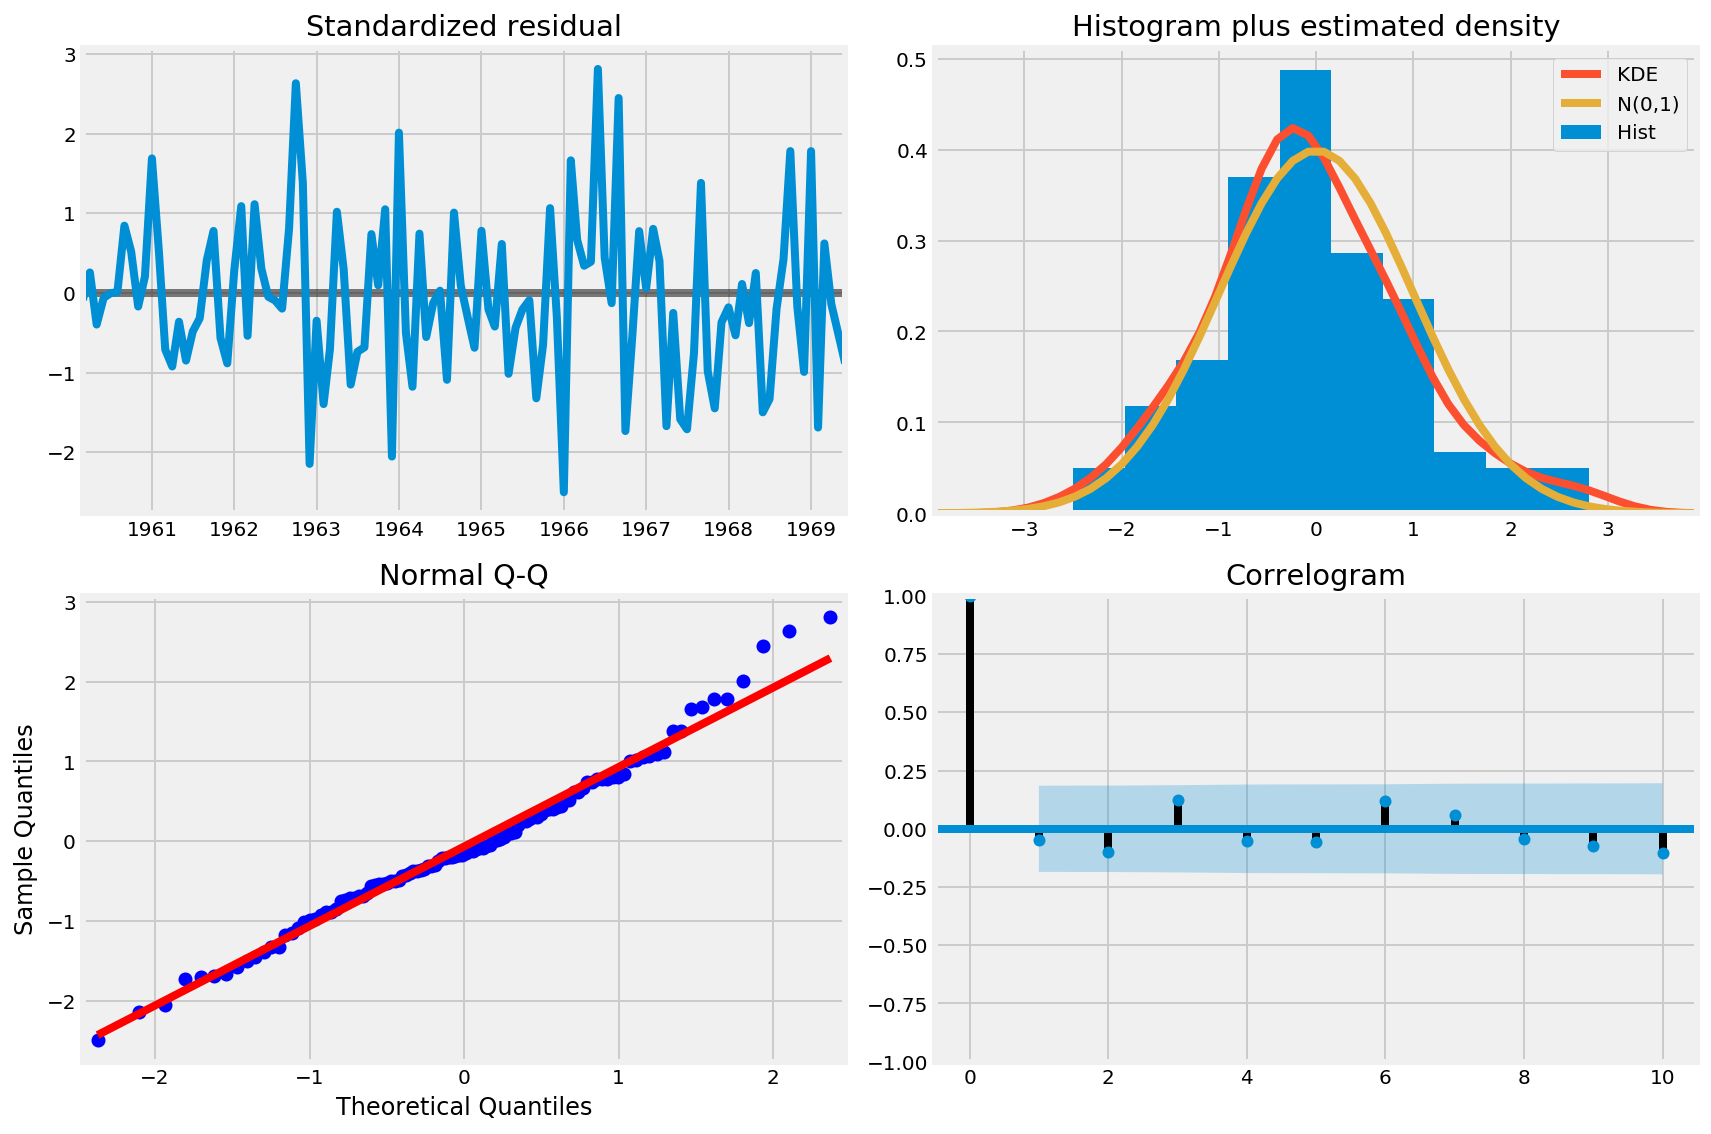

In [58]:
results.plot_diagnostics(figsize=(12,8))
plt.tight_layout()
plt.show()

### Forecast using the SARIMAX model

Statsmodels result objects from SARIMAX have a `.forecast` function that can use the state space model to predict future timepoints.

Forecast additional timepoints and plot them.

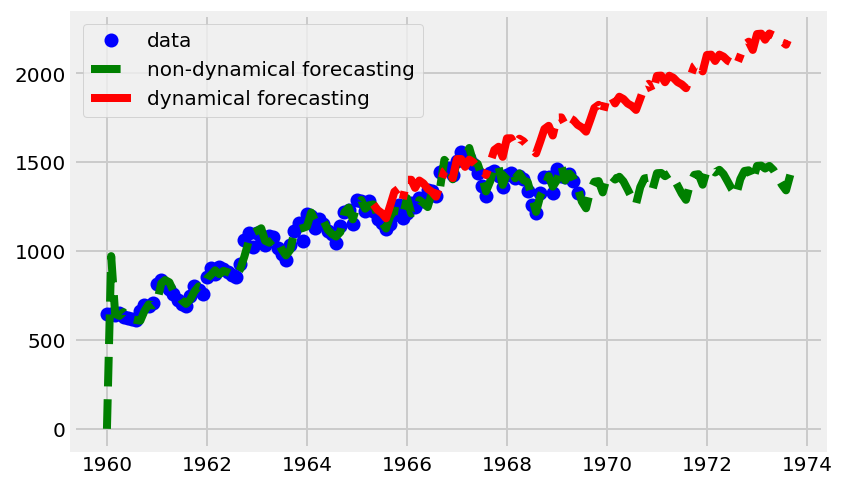

In [59]:
# forecasting
start_p = 50

# two equivalent ways for getting non-dynamical forecasts
# preds = results.forecast(50)
preds = results.predict(start=0,end=len(data)+50,dynamic=False)

preds_dyn = results.predict(start=len(data)-start_p,end=len(data)+50, dynamic=True)
fcast = pd.concat([data,preds])
fcast_1 = pd.concat([data[:len(data)-start_p],preds_dyn])


plt.figure()
plt.plot(data, 'bo' , preds, 'g--',preds_dyn,'r-.')
plt.legend(['data','non-dynamical forecasting','dynamical forecasting'])
plt.show()

In [60]:
from sklearn.metrics import r2_score, mean_squared_error

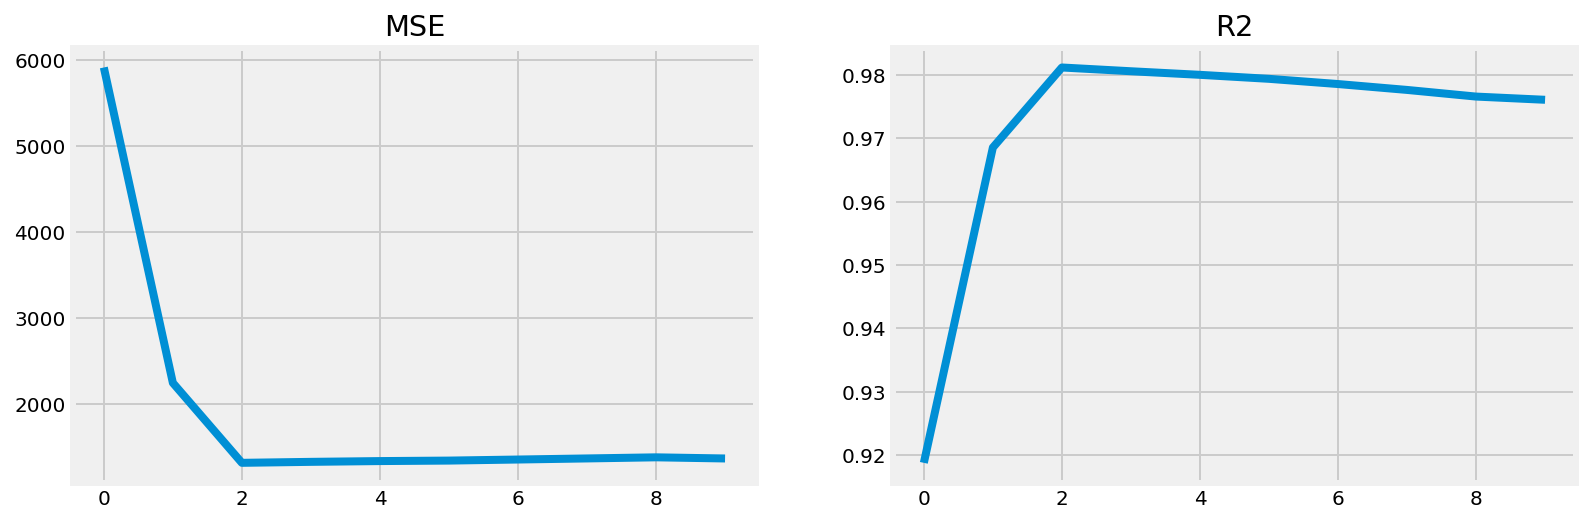

In [61]:
fig, ax = plt.subplots(ncols=2,figsize=(12,4))
ax[0].plot([mean_squared_error(data[i:],preds[i:len(data)]) for i in range(10)])
ax[0].set_title('MSE')
ax[1].plot([r2_score(data[i:],preds[i:len(data)]) for i in range(10)])
ax[1].set_title('R2')
plt.show()

### Force coefficients to zero

Instead of simply indicating orders $p$ and $q$, we can pass for each parameter a list of binary values indicating which lag to include and which one to exclude. That is also very convenient for pure ARIMA models.

(In this case, this is not a model improvement.)

In [62]:
model = sm.tsa.statespace.SARIMAX(data, 
                                  order=((0,1,1,0),1,(0,1)), 
                                  seasonal_order=(1,0,1,12))
results = model.fit()
results.summary()

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                                         Statespace Model Results                                         
==========================================================================================================
Dep. Variable:                                             riders   No. Observations:                  114
Model:             SARIMAX((2, 3), 1, (2,))x((12,), 0, (12,), 12)   Log Likelihood                -566.801
Date:                                            Tue, 20 Aug 2019   AIC                           1145.603
Time:                                                    07:57:09   BIC                           1161.967
Sample:                                                01-01-1960   HQIC                          1152.243
                                                     - 06-01-1969                                         
Covariance Type:                                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L2         -0.0639      0.622     -0.103      0.918      -1.283       1.156
ar.L3          0.1230      0.096      1.284      0.199      -0.065       0.311
ma.L2         -0.0189      0.613     -0.031      0.975      -1.221       1.183
ar.S.L12       0.9572      0.033     29.390      0.000       0.893       1.021
ma.S.L12      -0.5789      0.124     -4.676      0.000      -0.821      -0.336
sigma2      1163.6375    169.633      6.860      0.000     831.163    1496.112
===================================================================================
Ljung-Box (Q):                       28.66   Jarque-Bera (JB):                 2.88
Prob(Q):                              0.91   Prob(JB):                         0.24
Heteroskedasticity (H):               1.58   Skew:                             0.34
Prob(H) (two-sided):                  0.16   Kurtosis:                         3.37
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

## Dickey-Fuller test of stationarity
---

Now we have many different options for performing differencing. Having reached stationarity can be judged in similar ways as before by eye inspection. However, a statistical test might give a more informed statement. We can use the 
[(augmented) Dickey-Fuller test of stationarity](https://en.wikipedia.org/wiki/Augmented_Dickey%E2%80%93Fuller_test) to evaluate whether or not the timeseries is stationary.


In [64]:
# define Dickey-Fuller test
from statsmodels.tsa.stattools import adfuller

def test_stationarity(timeseries,maxlag=None,regression='c',autolag='AIC'):
    '''Perform Dickey-Fuller test and print out results'''
    
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries,maxlag=maxlag,regression=regression,autolag=autolag)
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in list(dftest[4].items()):
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput) 

def rolling(timeseries,window=12,center=True,figsize=(12,8)):
    '''
    Plot original timeseries, 
    rolling mean over given window size and rolling 
    mean plus/minus standard deviation
    '''
    
    rolmean = timeseries.rolling(window=window, center=center).mean()
    rolstd = timeseries.rolling(window=window, center=center).std()

    #Plot rolling statistics:
    fig = plt.figure(figsize=figsize)
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std_plus = plt.plot(rolmean+rolstd, color='red',ls='--', label = 'Rolling Mean +/- Rolling Std')
    std_minus = plt.plot(rolmean-rolstd, color='red',ls='--',label= '')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show()  

def autocorrelation_plot(timeseries,lags=None):
    '''Plot autocorrelations and partial autocorrelations'''
    fig, ax = plt.subplots(ncols=2,figsize=(12,4))
    plot_acf(timeseries, lags=lags, ax=ax[0])
    plot_pacf(timeseries, lags=lags, ax=ax[1])
    plt.show()

def test_and_vis(timeseries):
    '''
    Perform Dickey-Fuller test, 
    plot timeseries with rolling mean and autocorrelations
    '''
    test_stationarity(timeseries.dropna())
    rolling(timeseries)
    autocorrelation_plot(timeseries.dropna())

<a id="perform-test-on-the-original-timeseries"></a>
### Perform test on the original timeseries

Results of Dickey-Fuller Test:
Test Statistic                  -1.536597
p-value                          0.515336
#Lags Used                      12.000000
Number of Observations Used    101.000000
Critical Value (1%)             -3.496818
Critical Value (5%)             -2.890611
Critical Value (10%)            -2.582277
dtype: float64


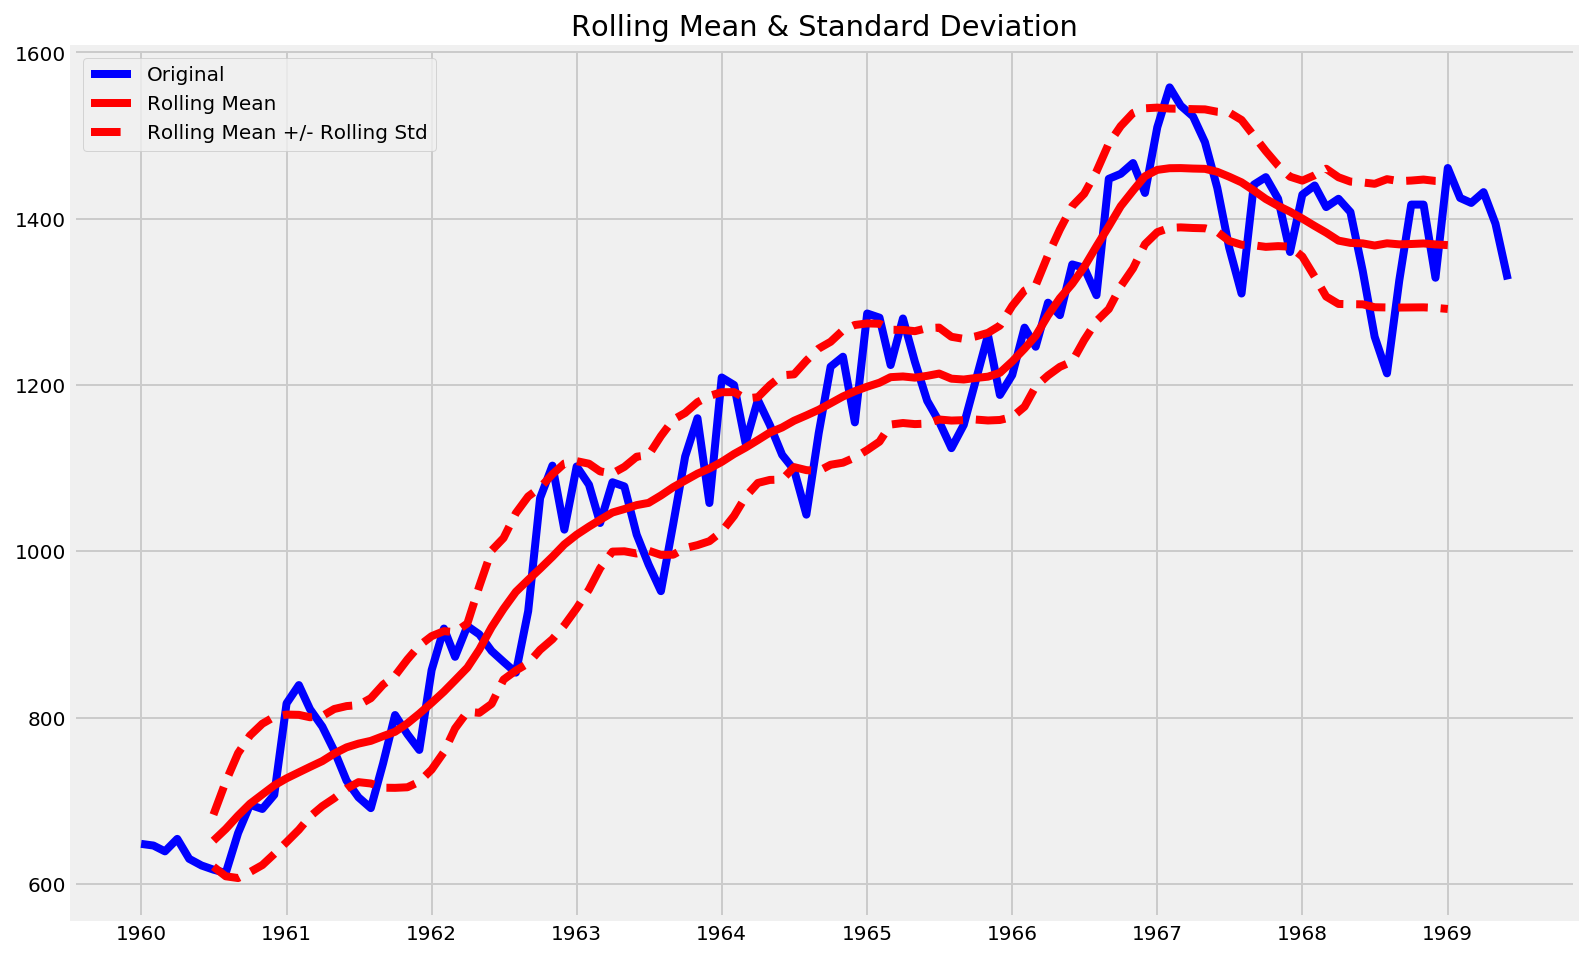

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1283: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


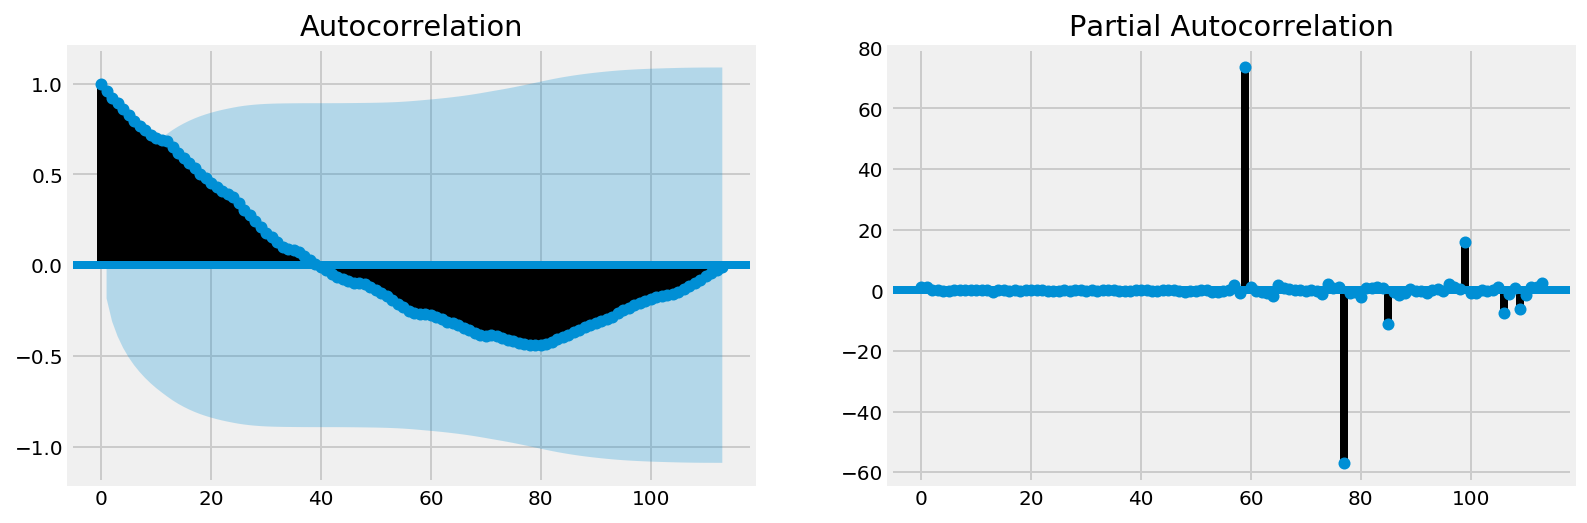

In [65]:
test_and_vis(bus.riders)

<a id="perform-test-on-the-first-differenced-timeseries"></a>
### Perform test on the first-differenced timeseries

Results of Dickey-Fuller Test:
Test Statistic                  -1.938696
p-value                          0.314082
#Lags Used                      11.000000
Number of Observations Used    101.000000
Critical Value (1%)             -3.496818
Critical Value (5%)             -2.890611
Critical Value (10%)            -2.582277
dtype: float64


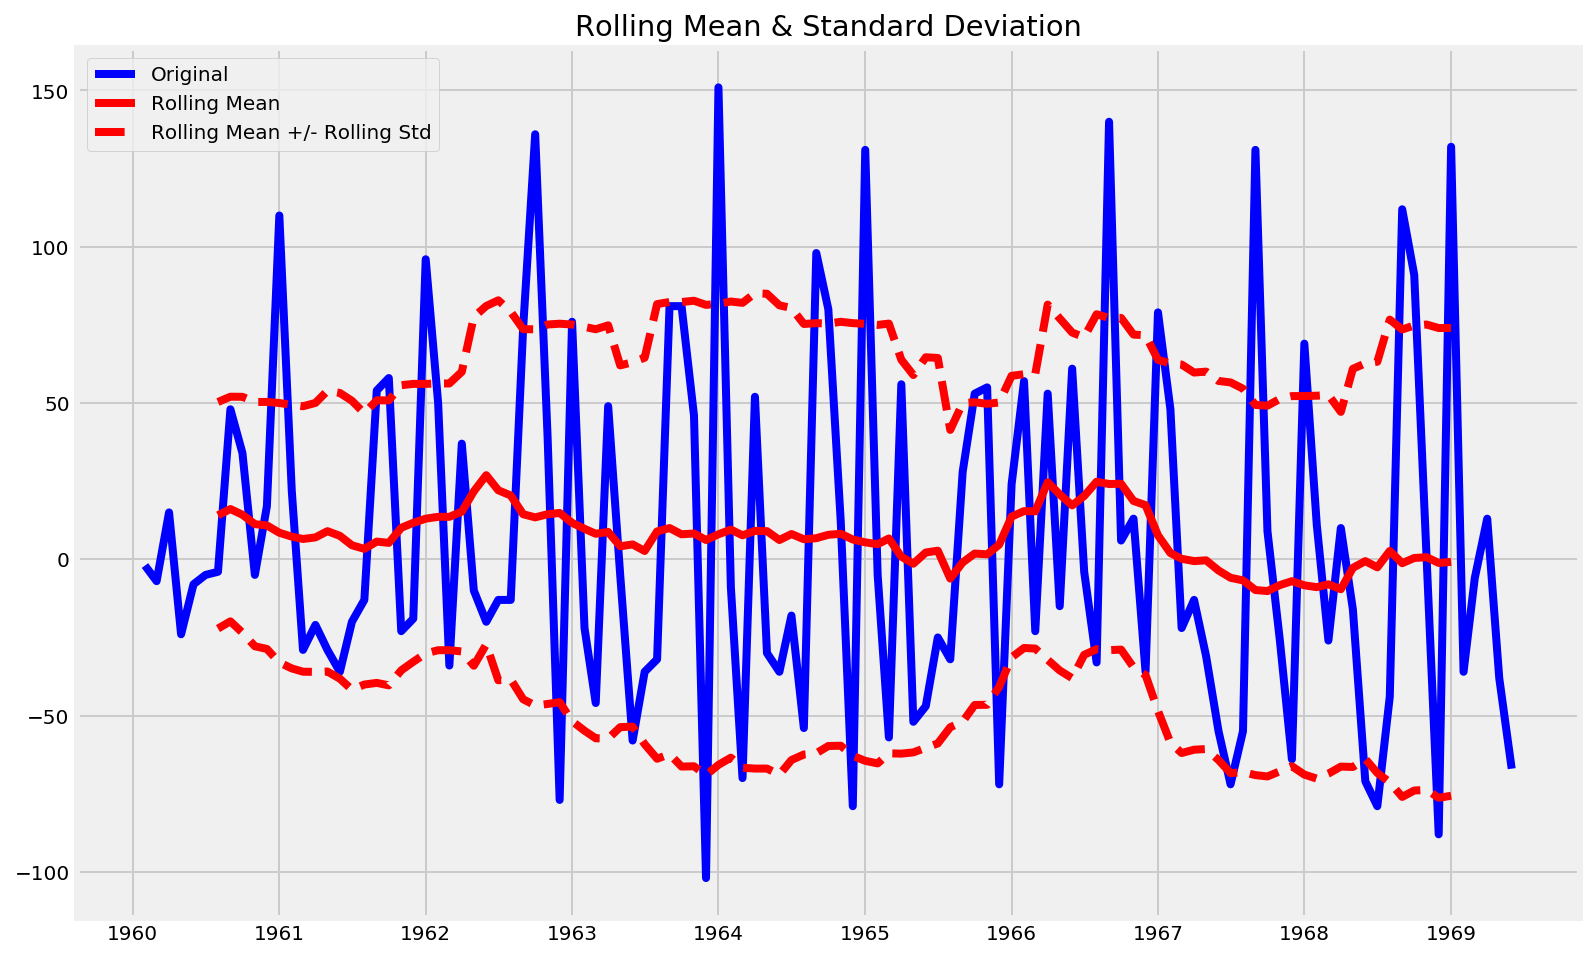

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1283: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


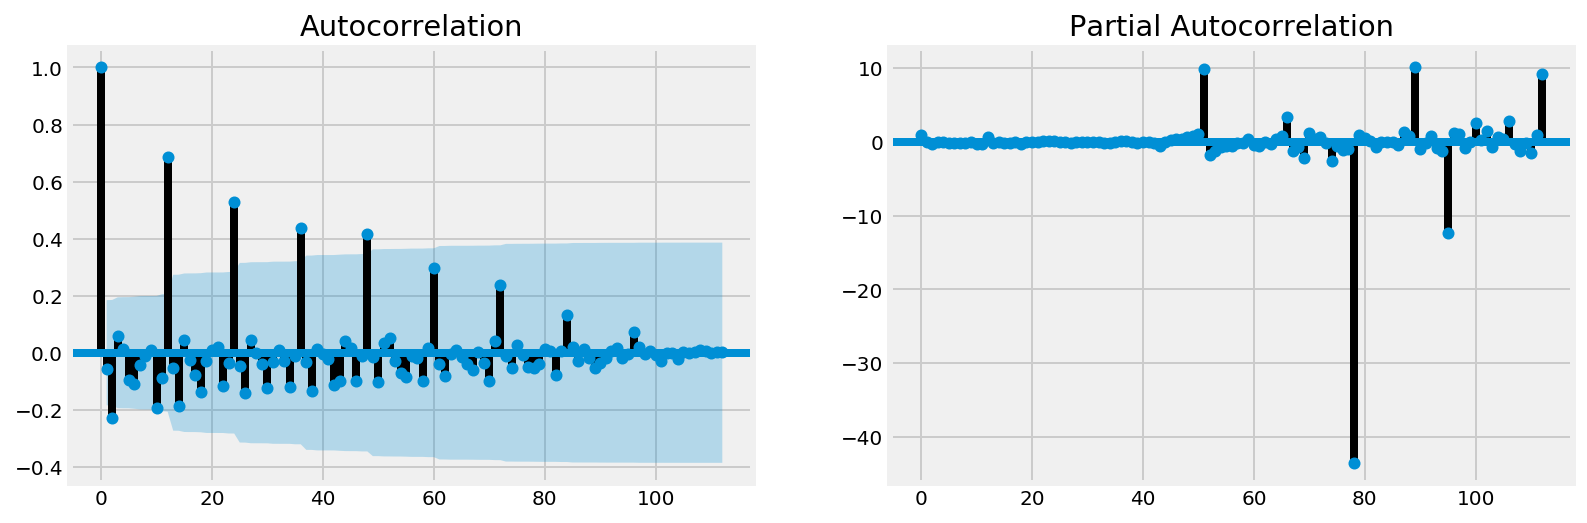

In [66]:
test_and_vis(bus.first_difference)

<a id="perform-test-on-the-second-differenced-timeseries"></a>
### Perform test on the second-differenced timeseries

Results of Dickey-Fuller Test:
Test Statistic                -1.247869e+01
p-value                        3.126378e-23
#Lags Used                     1.000000e+01
Number of Observations Used    1.010000e+02
Critical Value (1%)           -3.496818e+00
Critical Value (5%)           -2.890611e+00
Critical Value (10%)          -2.582277e+00
dtype: float64


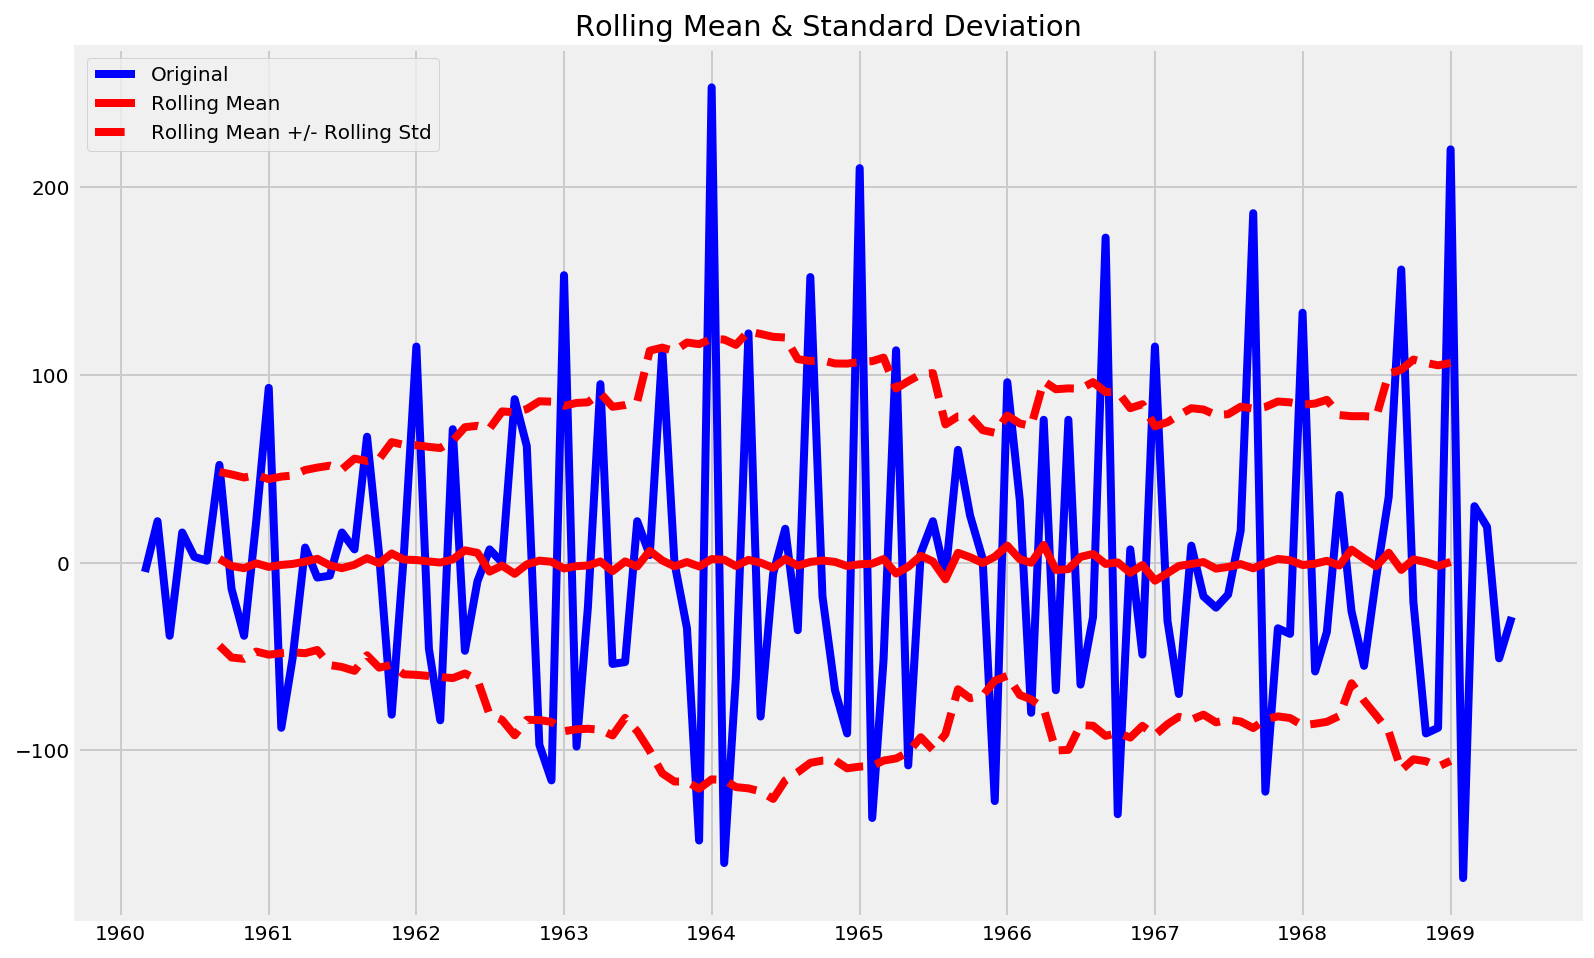

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1283: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


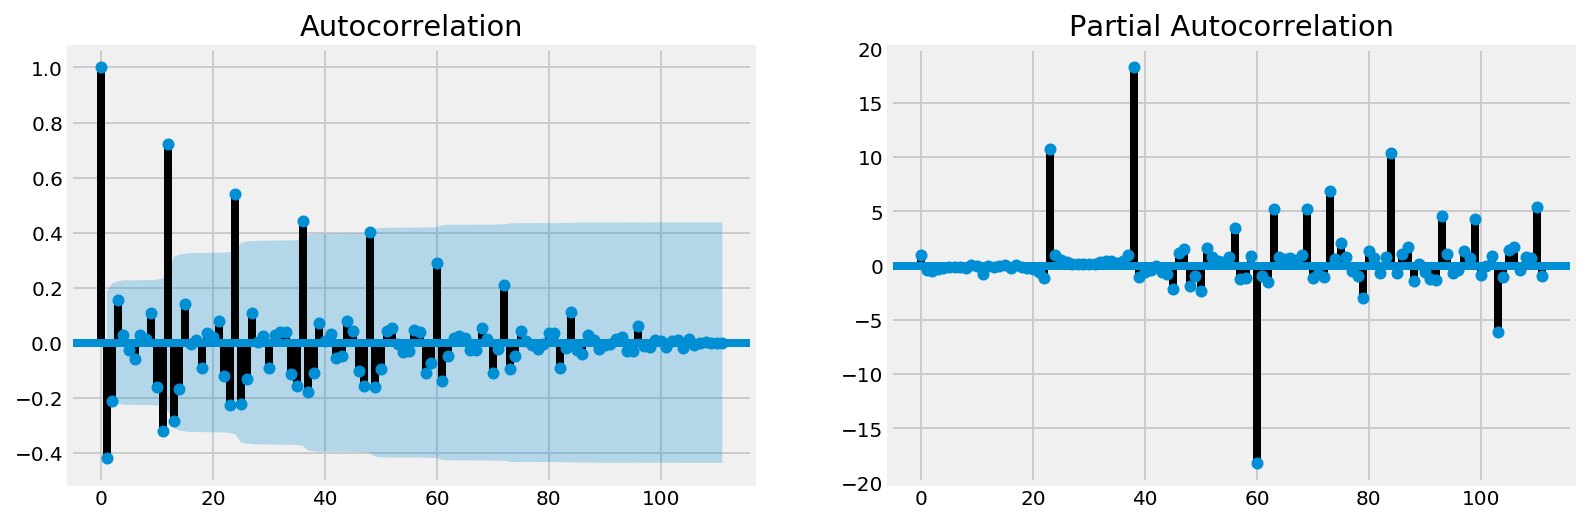

In [67]:
test_and_vis(bus.second_difference)

<a id="perform-test-on-seasonal-differenced-timeseries"></a>
### Perform test on *seasonally*-differenced timeseries

Where the season will be a year's difference (12 months).

Results of Dickey-Fuller Test:
Test Statistic                 -2.469741
p-value                         0.123011
#Lags Used                      3.000000
Number of Observations Used    98.000000
Critical Value (1%)            -3.498910
Critical Value (5%)            -2.891516
Critical Value (10%)           -2.582760
dtype: float64


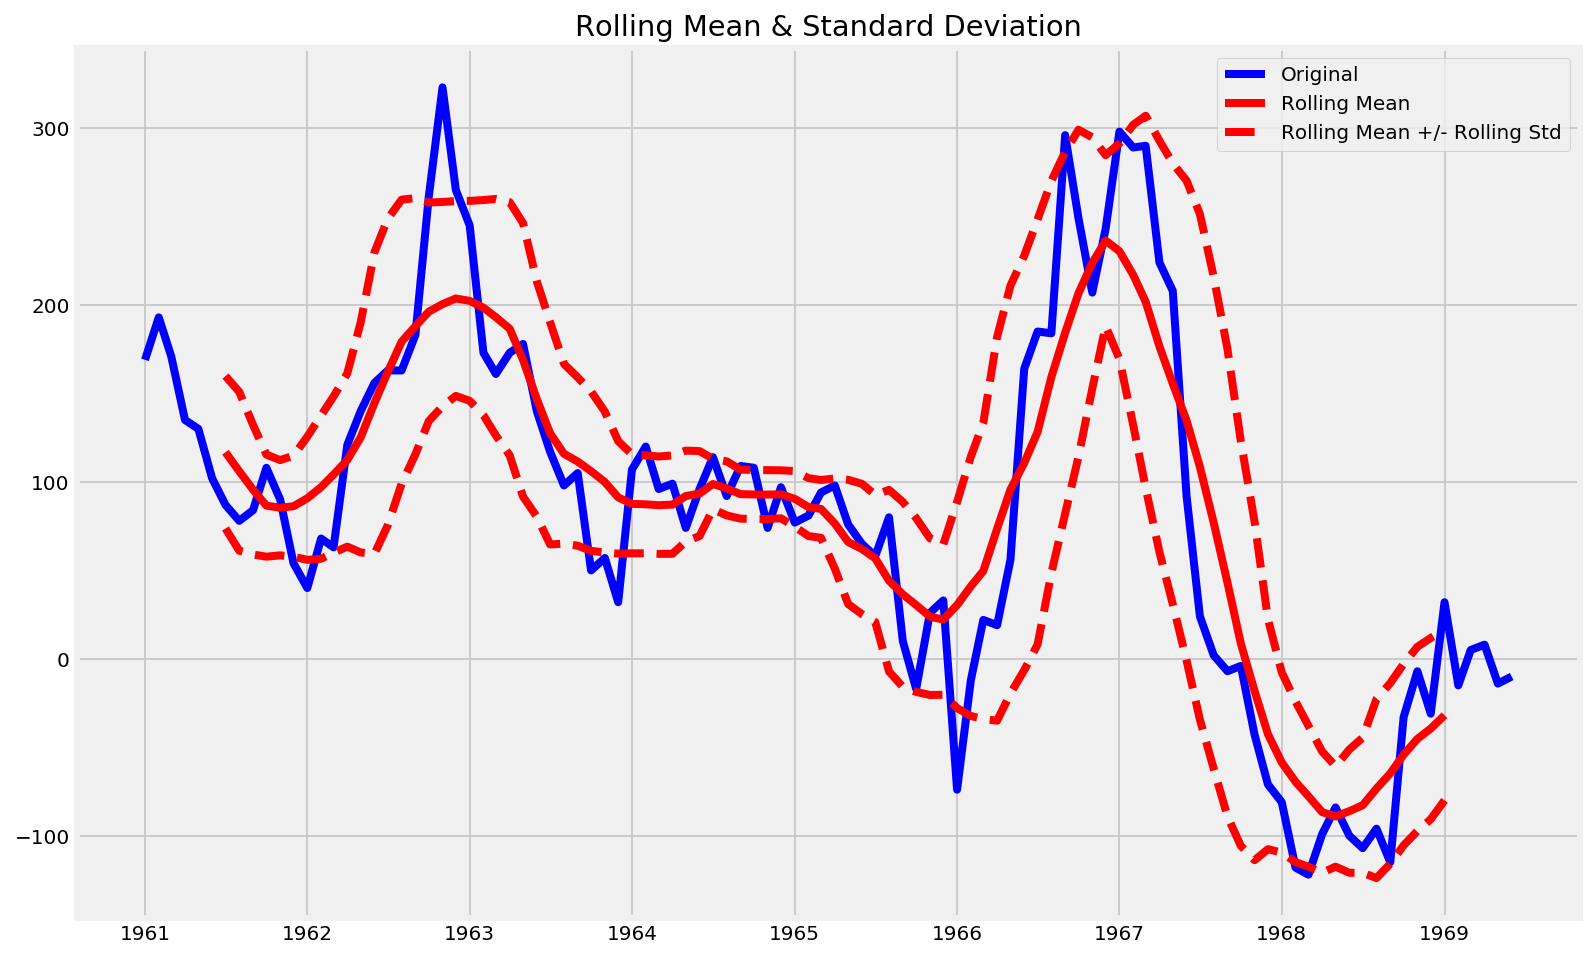

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1283: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


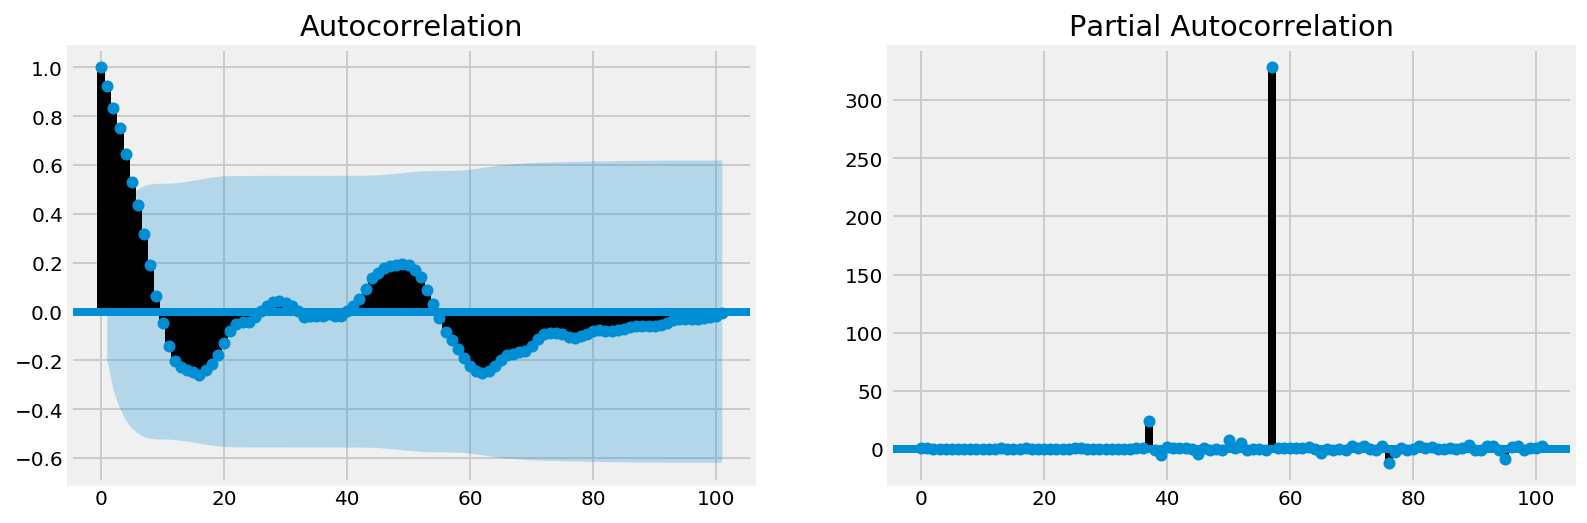

In [68]:
test_and_vis(bus.seasonal_difference)

### Perform a test on the first differenced seasonally differenced timeseries

At this point we can see that we have a significant result!

Results of Dickey-Fuller Test:
Test Statistic                -9.258520e+00
p-value                        1.427874e-15
#Lags Used                     0.000000e+00
Number of Observations Used    1.000000e+02
Critical Value (1%)           -3.497501e+00
Critical Value (5%)           -2.890906e+00
Critical Value (10%)          -2.582435e+00
dtype: float64


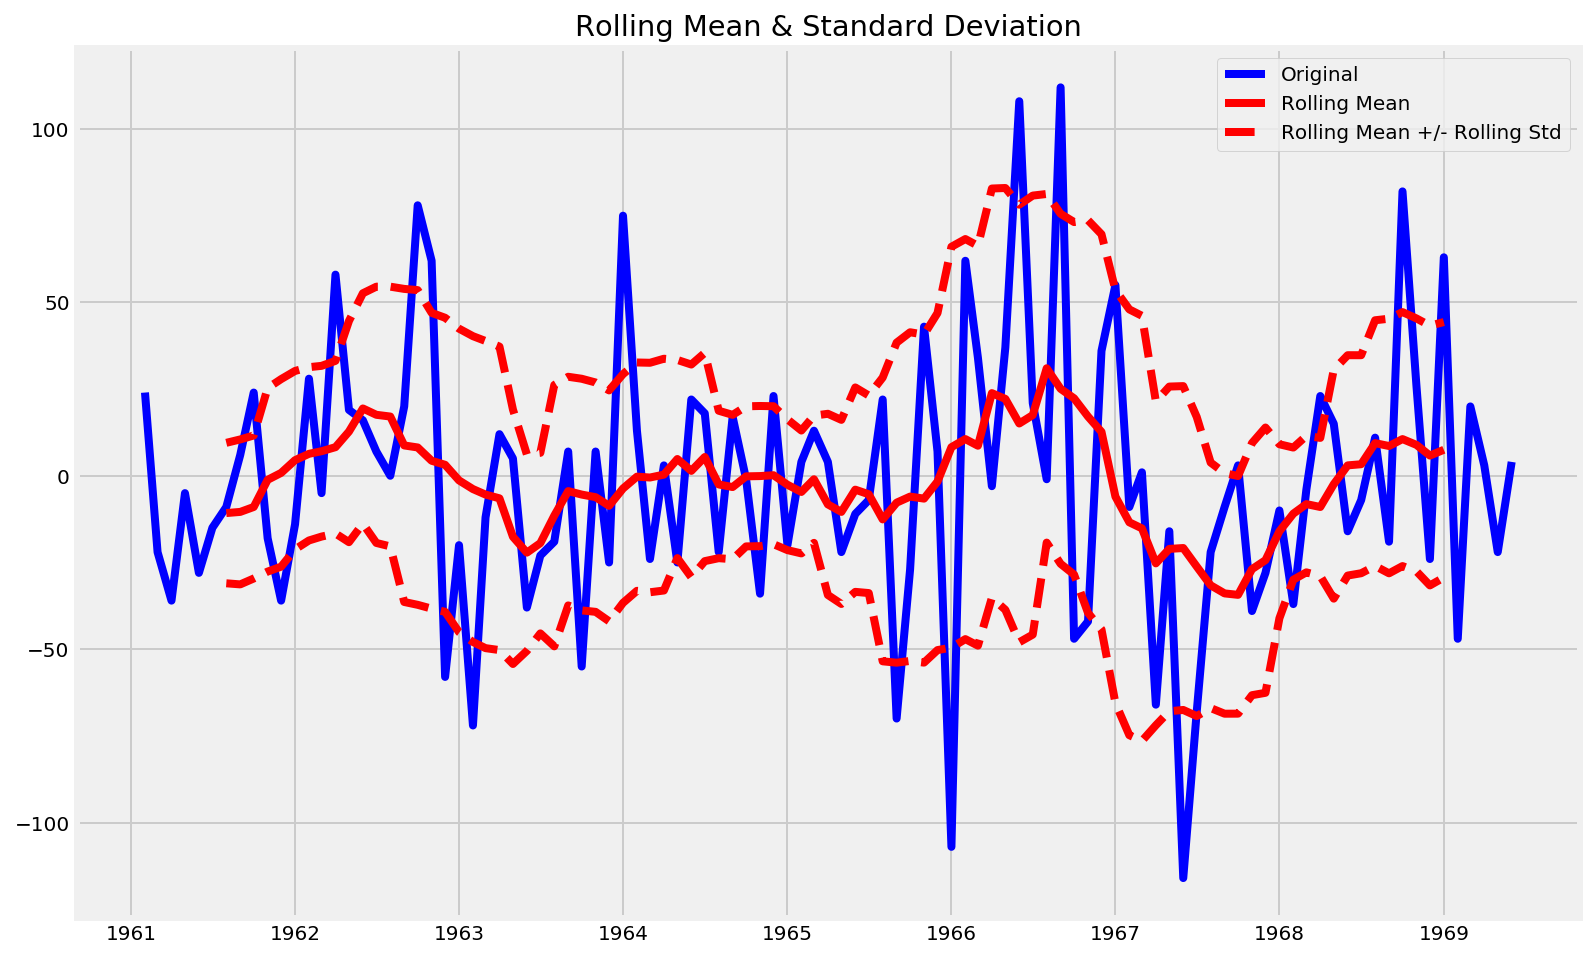

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1283: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


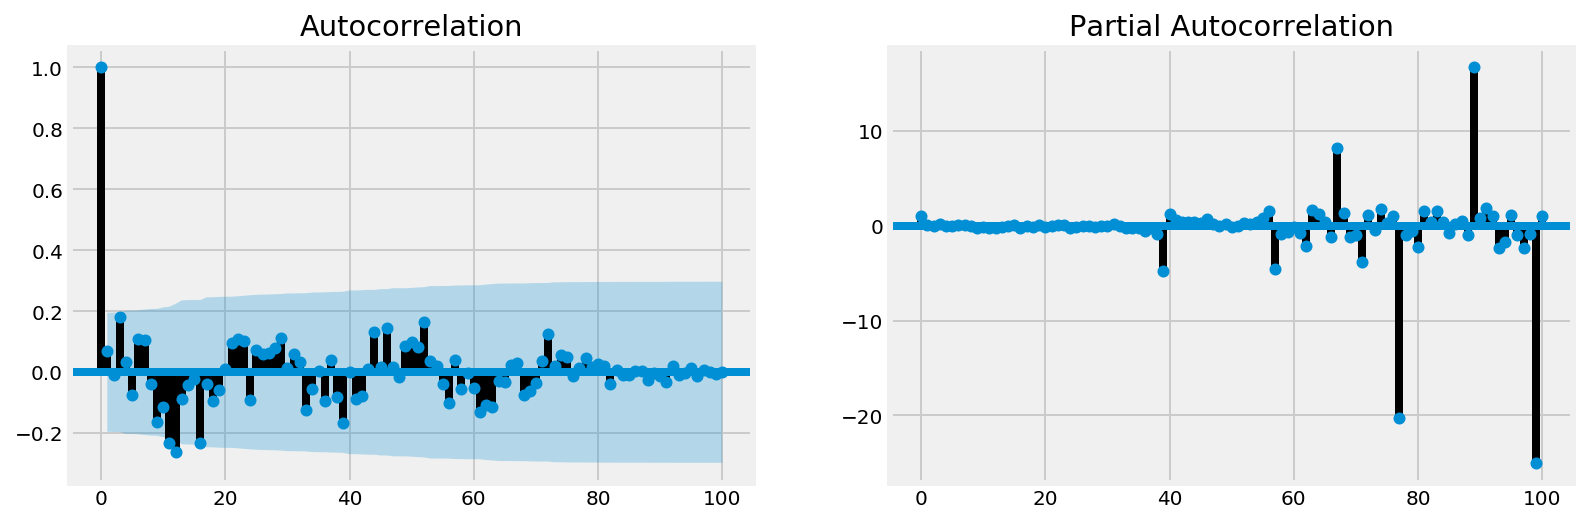

In [69]:
# first seasonal difference
test_and_vis(bus.seasonal_first_difference)

Results of Dickey-Fuller Test:
Test Statistic                -9.258520e+00
p-value                        1.427874e-15
#Lags Used                     0.000000e+00
Number of Observations Used    1.000000e+02
Critical Value (1%)           -3.497501e+00
Critical Value (5%)           -2.890906e+00
Critical Value (10%)          -2.582435e+00
dtype: float64


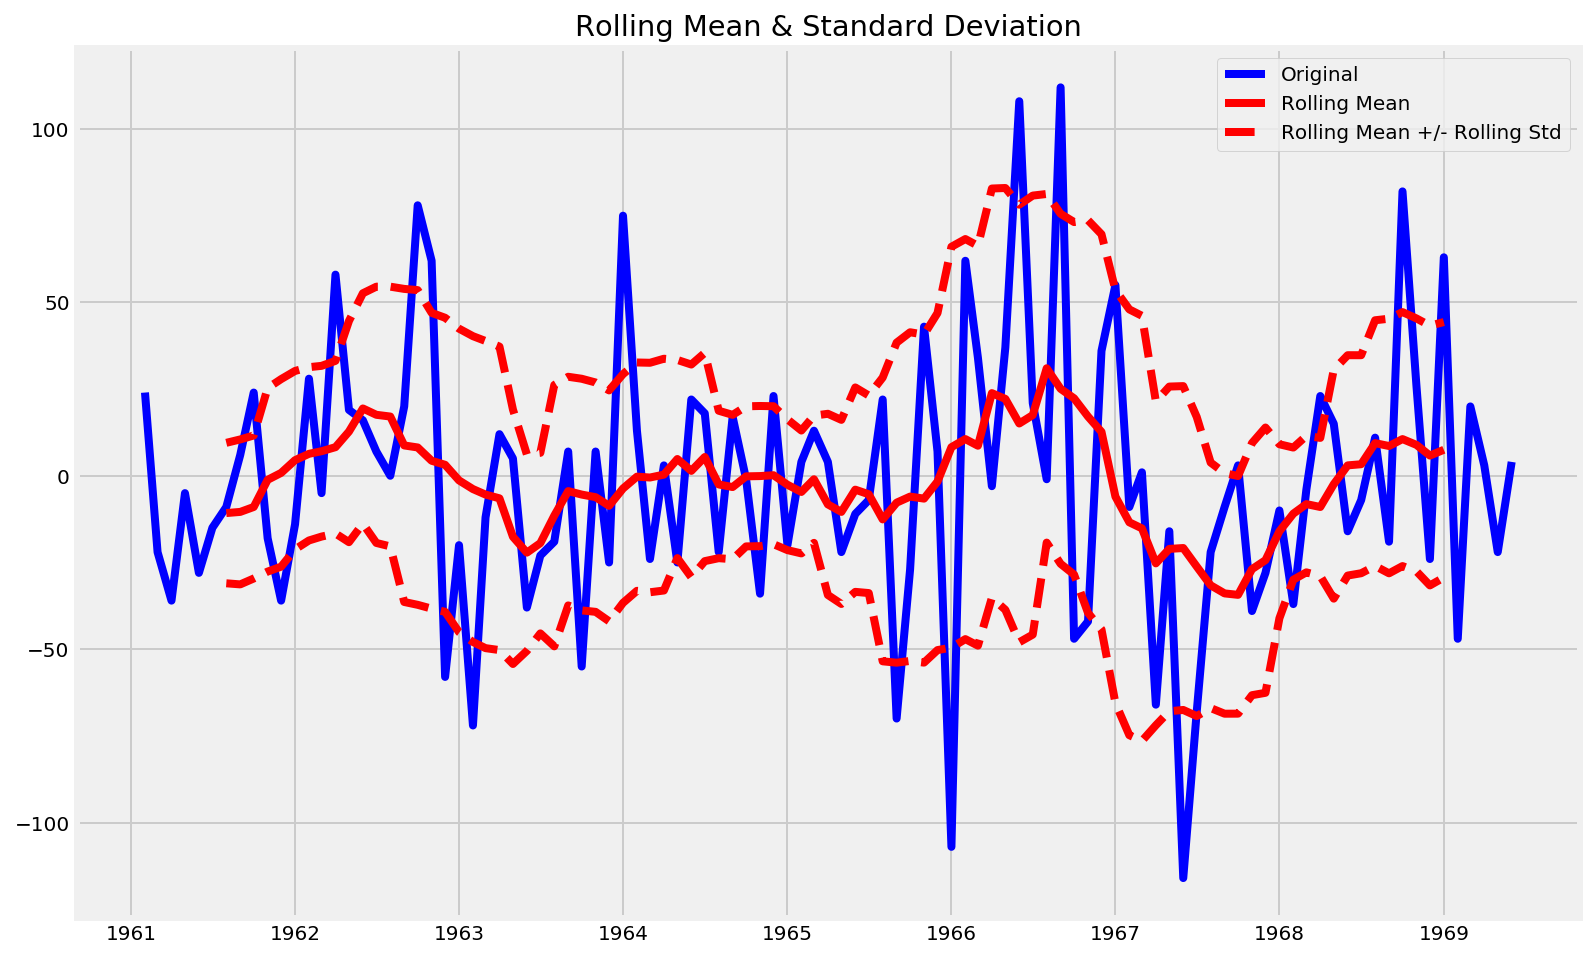

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1283: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


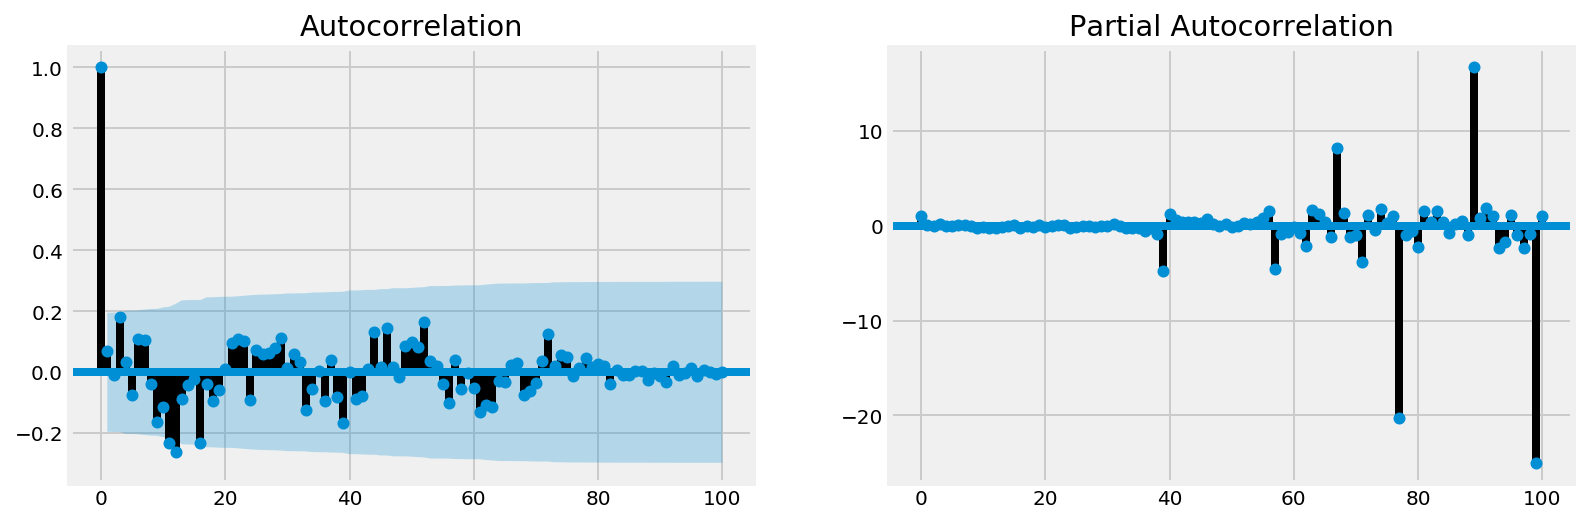

In [70]:
# first seasonal difference
test_and_vis(bus.seasonal_first_difference)

<a id="perform-test-on-the-second-seasonal-differenced-timeseries"></a>
### Perform test on the second differenced seasonally differenced timeseries

Results of Dickey-Fuller Test:
Test Statistic                -6.853777e+00
p-value                        1.668418e-09
#Lags Used                     5.000000e+00
Number of Observations Used    9.400000e+01
Critical Value (1%)           -3.501912e+00
Critical Value (5%)           -2.892815e+00
Critical Value (10%)          -2.583454e+00
dtype: float64


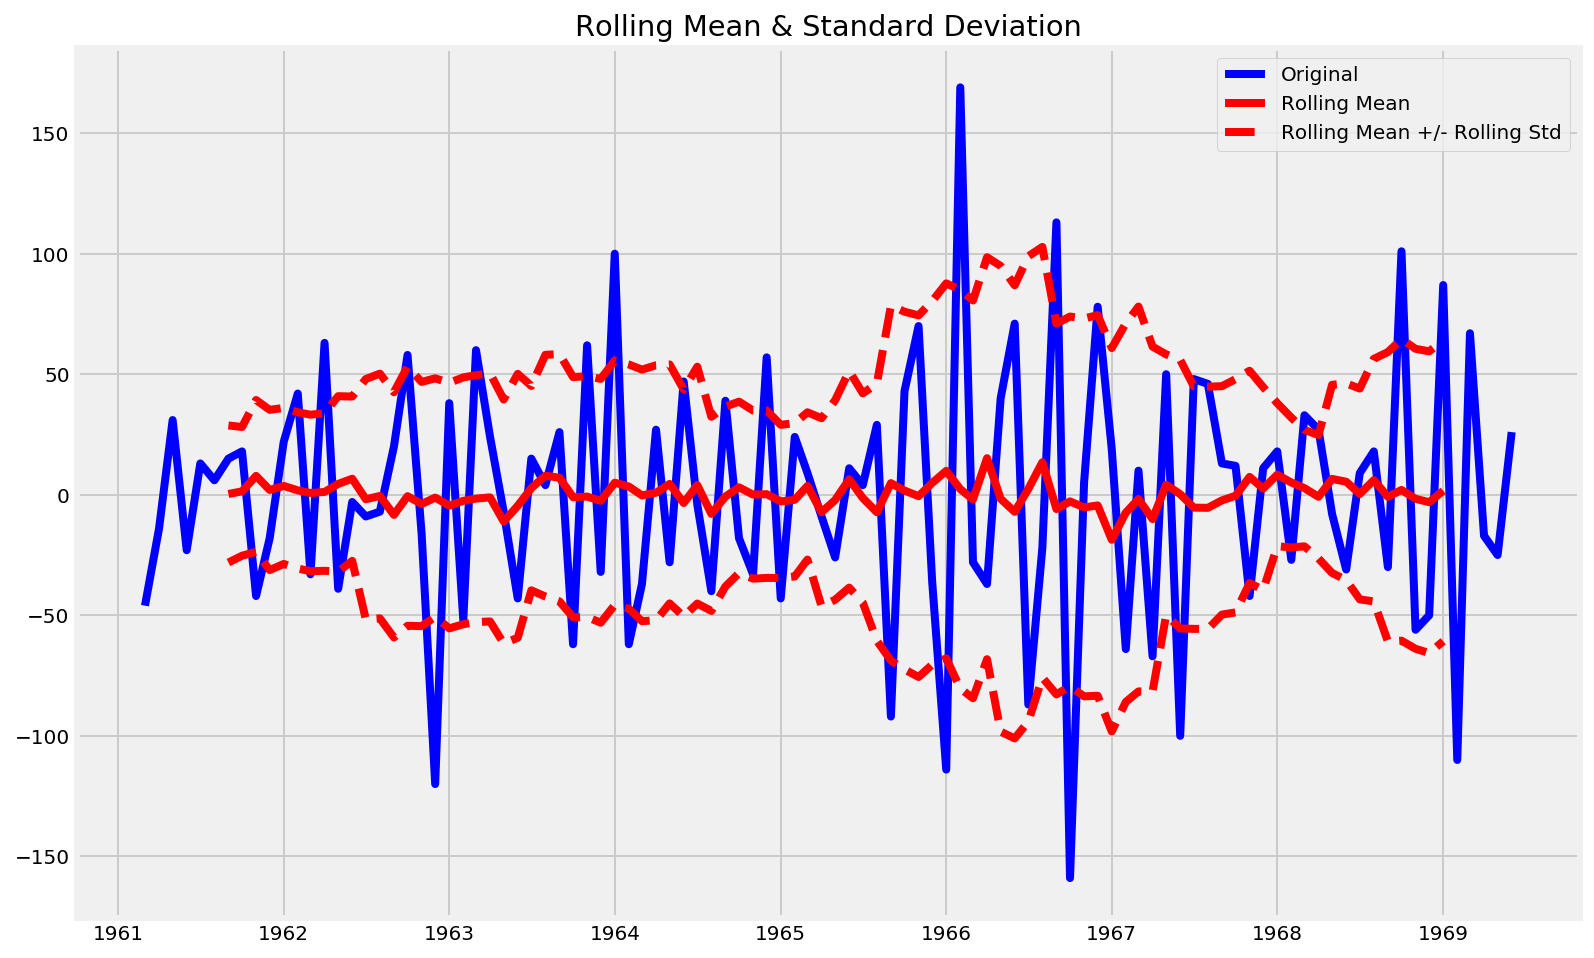

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1283: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


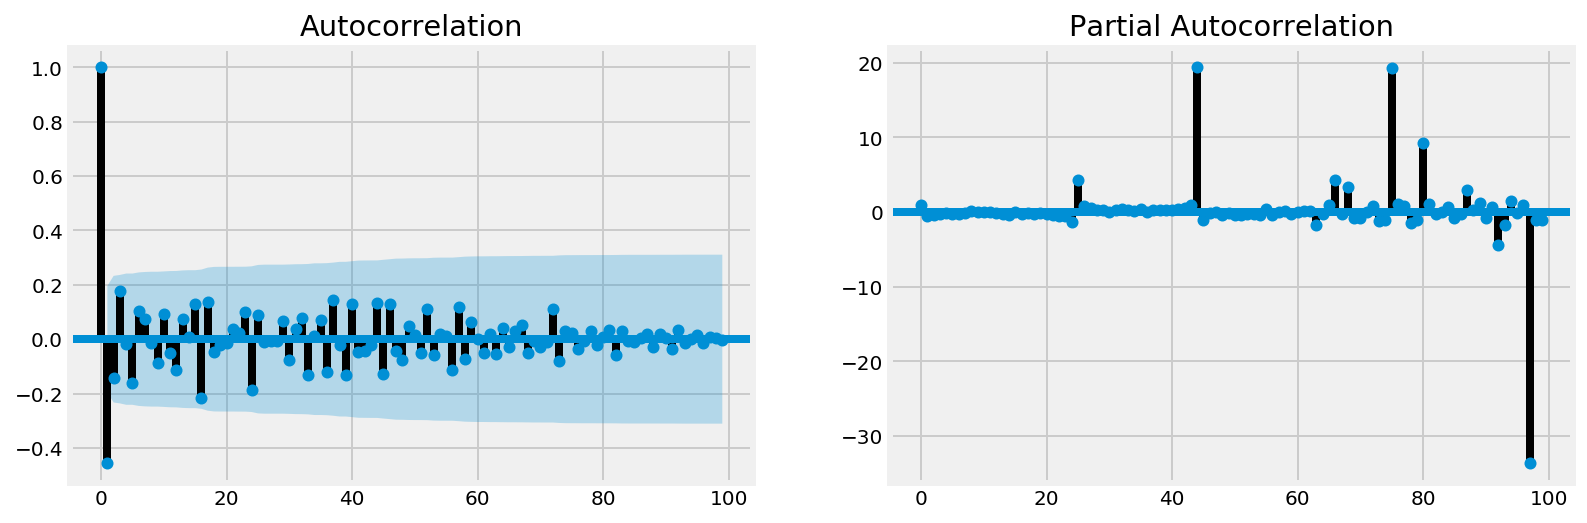

In [71]:
test_and_vis(bus.seasonal_second_difference)

In [72]:
for col in bus.columns:
    print('p-value', col)
    print('\t\t', adfuller(bus[col].dropna())[1])

p-value riders
		 0.5153358797821737
p-value first_difference
		 0.3140818370608518
p-value second_difference
		 3.1263782158277454e-23
p-value seasonal_difference
		 0.12301141534048143
p-value seasonal_first_difference
		 1.4278735579594827e-15
p-value seasonal_second_difference
		 1.6684179920522294e-09


### Conclusions

Time series decomposition and analysis of autocorrelations will be the starting point of any time series analysis. They will give us useful information about which model to use.

<a id='additional-resources'></a>
## Additional resources
---


+ A Seasonal ARIMA [code-along](http://www.statsmodels.org/dev/examples/notebooks/generated/statespace_sarimax_stata.html) from statsmodels
+ An excellent [blog code-along](http://www.seanabu.com/2016/03/22/time-series-seasonal-ARIMA-model-in-python/) to Seasonal ARIMA + [iPython noteback](https://github.com/seanabu/seanabu.github.io/blob/master/Seasonal_ARIMA_model_Portland_transit.ipynb)
+ Duke's breakdown of [ACF and PACF](http://people.duke.edu/~rnau/411arim3.htm)
+ Duke's breakdown of available [stationarity transformations](http://people.duke.edu/~rnau/whatuse.htm)
+ A 35min [video econometric](https://www.youtube.com/watch?v=Y2khrpVo6qI) breakdown of ARIMA
+ [Wikipedia Dickey-Fuller](https://en.wikipedia.org/wiki/Dickey%E2%80%93Fuller_test)
+ Stats Exchange breakdown of [Augmented Dickey-Fuller](http://stats.stackexchange.com/questions/44647/which-dickey-fuller-test-should-i-apply-to-a-time-series-with-an-underlying-mode)
+ A walk-through of selecting pdq from [Duke](http://people.duke.edu/~rnau/411arim.htm)
+ Big data analytics with ARIMA [case study](http://sda-pakdd2014.weebly.com/uploads/2/4/0/8/24088081/7w12.pdf)
+ BONUS! Checkout [Granger Causality tests](https://en.wikipedia.org/wiki/Granger_causality)